# Seasonal Autoregressive Integrated Moving Average Model 
## (SARIMA)

In [24]:
# usual imports #
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [25]:
# ignore unwanted warnigs #
import warnings
warnings.filterwarnings(action='ignore')

In [26]:
# consistent plot size #
from pylab import rcParams
rcParams['figure.figsize']=12,5

In [27]:
# import common timeseries libraries #
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import month_plot,quarter_plot,plot_acf,plot_pacf

from pmdarima import auto_arima
from statsmodels.tsa.arima_model import ARIMA,ARMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [28]:
# import the dataset #
df = pd.read_csv('../Data/co2_mm_mlo.csv')

In [29]:
df.head()

,year,month,decimal_date,average,interpolated
0,1958,3,1958.208,315.71,315.71
1,1958,4,1958.292,317.45,317.45
2,1958,5,1958.375,317.50,317.50
3,1958,6,1958.458,NaN,317.10
4,1958,7,1958.542,315.86,315.86


In [30]:
df['date'] =  pd.to_datetime(dict(year=df['year'],month=df['month'],day=1))

In [31]:
df.head()

,year,month,decimal_date,average,interpolated,date
0,1958,3,1958.208,315.71,315.71,1958-03-01
1,1958,4,1958.292,317.45,317.45,1958-04-01
2,1958,5,1958.375,317.50,317.50,1958-05-01
3,1958,6,1958.458,NaN,317.10,1958-06-01
4,1958,7,1958.542,315.86,315.86,1958-07-01


In [32]:
df.set_index('date',inplace=True)

In [33]:
df.head()

,year,month,decimal_date,average,interpolated
date,,,,,
1958-03-01,1958,3,1958.208,315.71,315.71
1958-04-01,1958,4,1958.292,317.45,317.45
1958-05-01,1958,5,1958.375,317.50,317.50
1958-06-01,1958,6,1958.458,NaN,317.10
1958-07-01,1958,7,1958.542,315.86,315.86


In [34]:
df.index.freq = 'MS'

In [35]:
df.index

DatetimeIndex(['1958-03-01', '1958-04-01', '1958-05-01', '1958-06-01',
               '1958-07-01', '1958-08-01', '1958-09-01', '1958-10-01',
               '1958-11-01', '1958-12-01',
               ...
               '2018-02-01', '2018-03-01', '2018-04-01', '2018-05-01',
               '2018-06-01', '2018-07-01', '2018-08-01', '2018-09-01',
               '2018-10-01', '2018-11-01'],
              dtype='datetime64[ns]', name='date', length=729, freq='MS')

In [17]:
df.dropna(inplace=True)

In [36]:
len(df)

729

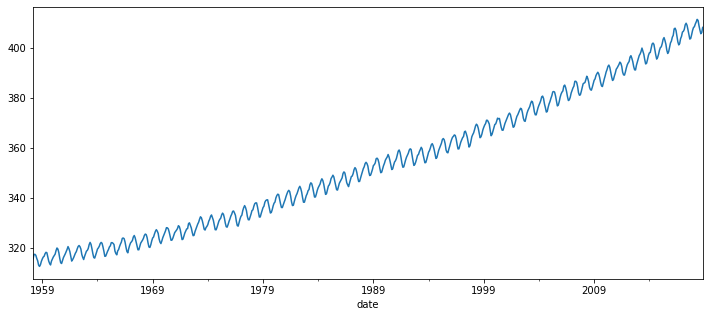

In [37]:
df['interpolated'].plot();

In [73]:
decompose = seasonal_decompose(df['interpolated'],model='additive')

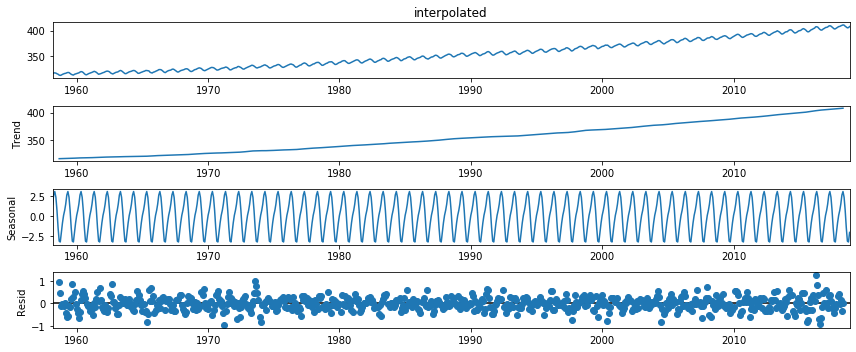

In [74]:
decompose.plot();

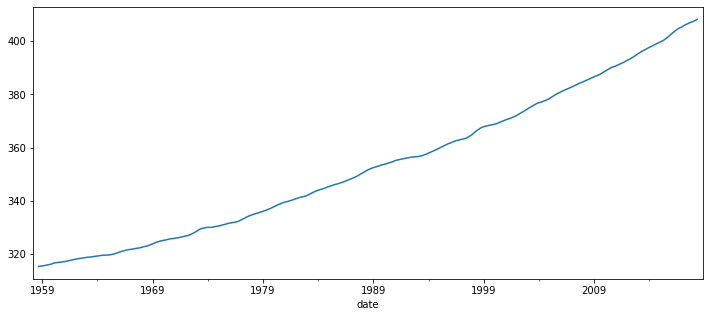

In [75]:
decompose.trend.plot()

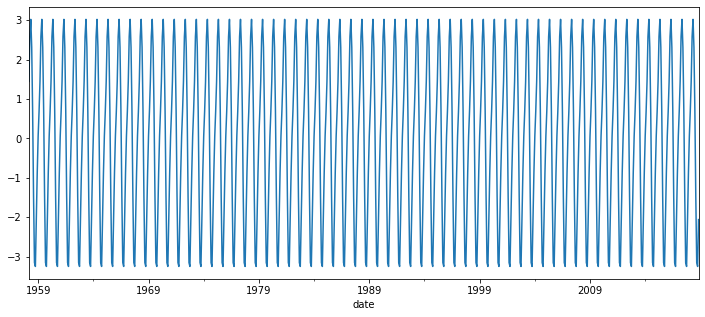

In [76]:
decompose.seasonal.plot()

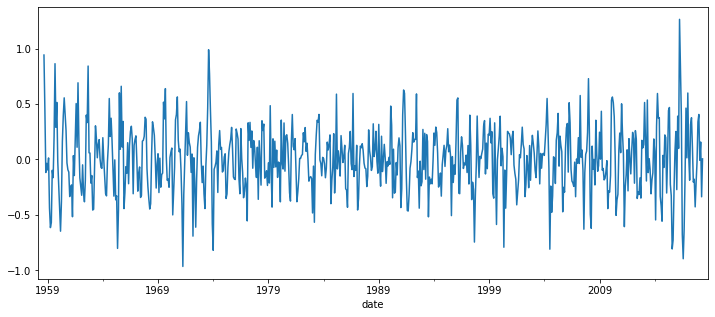

In [77]:
decompose.resid.plot()

In [52]:
# create a convenience function for dickey fuller test of stationarity #

def dickey_fuller(series,title='Your Dataset'):
    from statsmodels.tsa.stattools import adfuller
    
    print(f'Augmented Dickey Fuller Test of {title}\n')
    result = adfuller(series.dropna(),autolag='AIC')
    
    df = pd.Series(result[0:4],index=['test-statistics','p-Value','#lags','#obs'])
    
    print (df.to_string())
    
    for key,value in result[4].items():
        print (f'critical {key} value is {value}')
               
                 
    if result[1] < 0.05:
        print ('There is sufficient evidence against the Null Hypothesis')
        print ('We reject the Null Hypothesis')
        print ('Conclusion: The provided dataset is stationary')
    else:
        print ('There is not sufficient evidence against the Null Hypothesis')
        print ('We fail to reject the Null Hypothesis')
        print ('Conclusion: The provided dataset is non-stationary')

In [53]:
dickey_fuller(df['interpolated'],title ='CO2 Emission')

Augmented Dickey Fuller Test of CO2 Emission

test-statistics      4.994847
p-Value              1.000000
#lags               20.000000
#obs               708.000000
critical 1% value is -3.439620010600208
critical 5% value is -2.8656309041017756
critical 10% value is -2.5689484851894413
There is not sufficient evidence against the Null Hypothesis
We fail to reject the Null Hypothesis
Conclusion: The provided dataset is non-stationary


In [55]:
# determine the order of the ARMA/ ARIMA or SARIMA to be applied #
auto_arima(df['interpolated'],seasonal=True,m=12).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  729
Model:             SARIMAX(0, 1, 1)x(1, 0, 1, 12)   Log Likelihood                -209.374
Date:                            Sun, 12 Jul 2020   AIC                            428.748
Time:                                    07:19:02   BIC                            451.700
Sample:                                         0   HQIC                           437.604
                                            - 729                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   3.627e-05      0.000      0.316      0.752      -0.000       0.000
ma.L1         -0.3808      0.034    -11.128      0.000      -0.448      -0.314
ar.S.L12       0.9997      0.000   3327.065      0.000       0.999       1.000
ma.S.L12      -0.8662      0.021    -40.396      0.000      -0.908      -0.824
sigma2         0.0964      0.005     20.334      0.000       0.087       0.106
===================================================================================
Ljung-Box (Q):                       51.32   Jarque-Bera (JB):                 3.93
Prob(Q):                              0.11   Prob(JB):                         0.14
Heteroskedasticity (H):               1.13   Skew:                            -0.04
Prob(H) (two-sided):                  0.36   Kurtosis:                         3.35
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [56]:
# split the data onto the training and testing dataset #
train = df[:700]
test = df[700:]

In [59]:
# create the SARIMA model and fit the data #
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [60]:
model = SARIMAX(train['interpolated'],order=(0,1,1),seasonal_order=(1,0,1,12))

In [61]:
fitt = model.fit()

In [63]:
test_predictions = fitt.predict(start=len(train),end=len(train)+len(test)-1,dynamic=False,
                               typ='levels').rename('SARIMA TestPredictions')

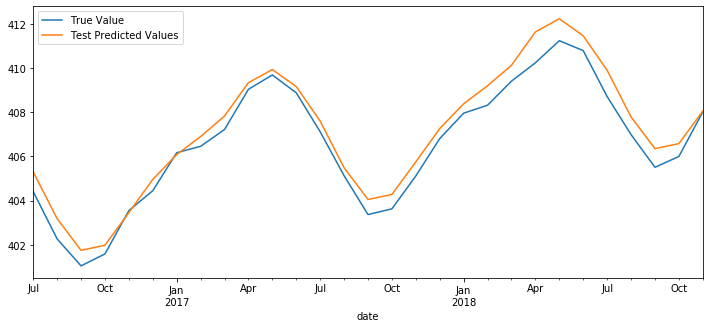

In [64]:
test['interpolated'].plot(legend=True,label='True Value')
test_predictions.plot(legend=True,label='Test Predicted Values')

In [65]:
# model evaluation #
from statsmodels.tools.eval_measures import rmse

In [66]:
rmse(test['interpolated'],test_predictions)

0.6742982751264375

In [67]:
test['interpolated'].describe().transpose()

count     29.000000
mean     406.522414
std        2.749121
min      401.050000
25%      404.450000
50%      406.810000
75%      408.710000
max      411.240000
Name: interpolated, dtype: float64

- We have an excellent predictive model 

In [68]:
# use the model for future forecast #
model = SARIMAX(df['interpolated'],order=(0,1,1),seasonal_order=(1,0,1,12))

In [69]:
fitt = model.fit()

In [71]:
forecast =fitt.predict(start=len(df),end=len(df)+24,dynamic=False,typ='levels').rename('SARIMA (0,1,1) (1,0,1,12)')

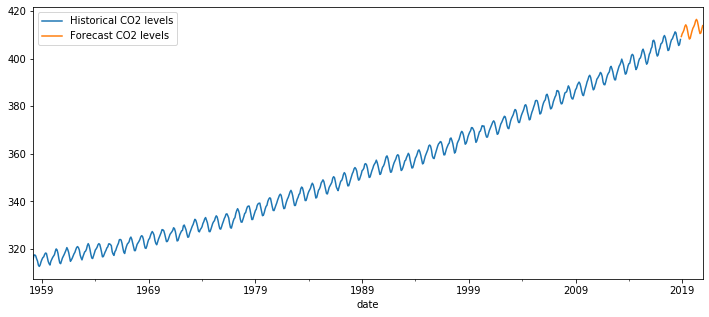

In [72]:
df['interpolated'].plot(legend=True,label='Historical CO2 levels')
forecast.plot(legend=True,label='Forecast CO2 levels')